In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Deep Learning Lab Assignment: Building a U-Net for Image Segmentation
Objective

The goal of this lab is to design and implement a U-Net neural network for image segmentation. The network will process infrared images captured by a camera mounted on an autonomous drone boat. The purpose of the segmentation task is to distinguish the sea from the sky. This segmentation will serve two primary purposes:  

*   Filtering out detections located in the sky.
*    Calculating the distance of a detection relative to the camera based on its distance from the horizon.
   

# Problem Context

Autonomous drone boats rely on visual data to make navigation and detection decisions. Infrared cameras are particularly useful in low-light or challenging environments, such as at night or during foggy conditions. However, to ensure accurate analysis, it is essential to segment the images to separate the sea from the sky.

In this lab, you will build and train a U-Net, a convolutional neural network architecture specifically designed for image segmentation tasks. The U-Net will label each pixel in the image as either "sea" or "sky." The resulting segmentation map will be used for filtering out false detections in the sky and estimating distances based on the location of the horizon.




# Exercise instructions
1.  You must answer the questions at the beginning of each paragraph  
2.  You must complete the code between #...#
3.  You must explain in comments the lines of code that you produce
4.  You can help and ask for help from others but you must indicate the person who helped you

### The person who helped me : Mateus Pedrosa

# Deliverables

1.   Python code for your U-Net implementation.
2.   The trained model (saved as a file)
3.   A report summarizing your findings and results ( plot evaluation loss, train loss and accuracy metric)

In [2]:
import zipfile
import os

project_path = "/content/drive/MyDrive/Unet/"
extract_path = "/content/drive/MyDrive/Unet/UUnet/"


zip_files = [
    project_path + "test_frames-20250112T193440Z-001.zip",
    project_path + "test_masks-20250112T193603Z-001.zip",
    project_path + "train_frames-20250112T192858Z-001.zip",
    project_path + "train_masks-20250112T192152Z-001.zip",
    project_path + "val_frames-20250112T193230Z-001.zip",
    project_path + "val_masks-20250112T193113Z-001.zip"
]


for zip_file in zip_files:
    print(f"Extracting: {zip_file}")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print(f"✅ finish (file saved in: {extract_path})")


Extracting: /content/drive/MyDrive/Unet/test_frames-20250112T193440Z-001.zip
Extracting: /content/drive/MyDrive/Unet/test_masks-20250112T193603Z-001.zip
Extracting: /content/drive/MyDrive/Unet/train_frames-20250112T192858Z-001.zip
Extracting: /content/drive/MyDrive/Unet/train_masks-20250112T192152Z-001.zip
Extracting: /content/drive/MyDrive/Unet/val_frames-20250112T193230Z-001.zip
Extracting: /content/drive/MyDrive/Unet/val_masks-20250112T193113Z-001.zip
✅ finish (file saved in: /content/drive/MyDrive/Unet/UUnet/)


In [22]:
import os
project_path = "/content/drive/MyDrive/Unet/"
data_set_path = "/content/drive/MyDrive/Unet/UUnet/"
TRAIN_IMG_DIR = os.path.join(data_set_path,"train_frames/train")
TRAIN_MASK_DIR = os.path.join(data_set_path,"train_masks/train")
VAL_IMG_DIR = os.path.join(data_set_path,"val_frames/val")
VAL_MASK_DIR = os.path.join(data_set_path,"val_masks/val")
CHECKPOINT_PATH = os.path.join(project_path,"Save/my_checkpoint.pth.tar")
PLOT_PATH = os.path.join(project_path,"Save/Accuracy")
PLOT_VAL_PATH = os.path.join(project_path,"Save/validation")

# Dataset
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pdb
import cv2

## Dataset Class
Questions:
1. Explain what the get_item function is for and how it is called in training mechanism?
2. why do we have to divide mask by 255?


Answers :

The __getitem__ function lets me load an image and its mask from the dataset. I use an index to find the file, open it, change the image to RGB and the mask to grayscale, and convert them into arrays for easier processing. If needed, I apply extra transformations before returning them.  

During training, the DataLoader automatically calls this function to get images in batches. For example, if the batch size is 4, it loads four images and masks at once before sending them to the model.  

I divide the mask by 255 to normalize its values. Since masks usually have pixel values between 0 and 255, this helps scale them between 0 and 1. This makes training smoother and helps the model learn better.

In [5]:
class HorizonDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)


    def __len__(self):
        return len(self.images)

# Create a HorizonDataset class that derives from the pytorch Dataset class and complete the __getitem__(self, index) method.
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        #...#
        # 1. Open the image and mask and convert
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        # 2. Convert the image to RGB
        image = image.convert("RGB")
        # 3. Convert the mask to gray scale
        mask = mask.convert("L")
        # 4. Convert the image and mask to 'np.array' type ,for easier preprocessing
        image = np.array(image)
        mask = np.array(mask)

        mask = mask/255.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return (image, mask)



## Loader definition
Questions:
1. Explain what the data loader is for?

Answer :

The data loader makes training more efficient by loading images and masks in small batches. It automatically fetches data instead of loading everything at once. In training, it shuffles the data to help the model learn better, but for validation, it keeps the order the same for consistent evaluation.

In [6]:
# The data loader allows you to iterate over the dataset.
# Each iteration below returns a batch of train_features and train_labels

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = HorizonDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

# Warning to shuffle (true or false ??? explain why in commentary)
    train_loader =  DataLoader(train_ds, shuffle=True,
                               batch_size=batch_size,
                               pin_memory = pin_memory ,num_workers=num_workers)

    val_ds = HorizonDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )
# Warning to shuffle (true or false ??? explain why in commentary)
    val_loader = DataLoader(val_ds, shuffle=False,
	  batch_size=batch_size, pin_memory=pin_memory,
	  num_workers=num_workers)

    return train_loader, val_loader

# Model definition
https://www.pinecone.io/learn/batch-layer-normalization/

https://medium.com/data-science-365/batch-normalization-explained-in-plain-english-3436014f9e52

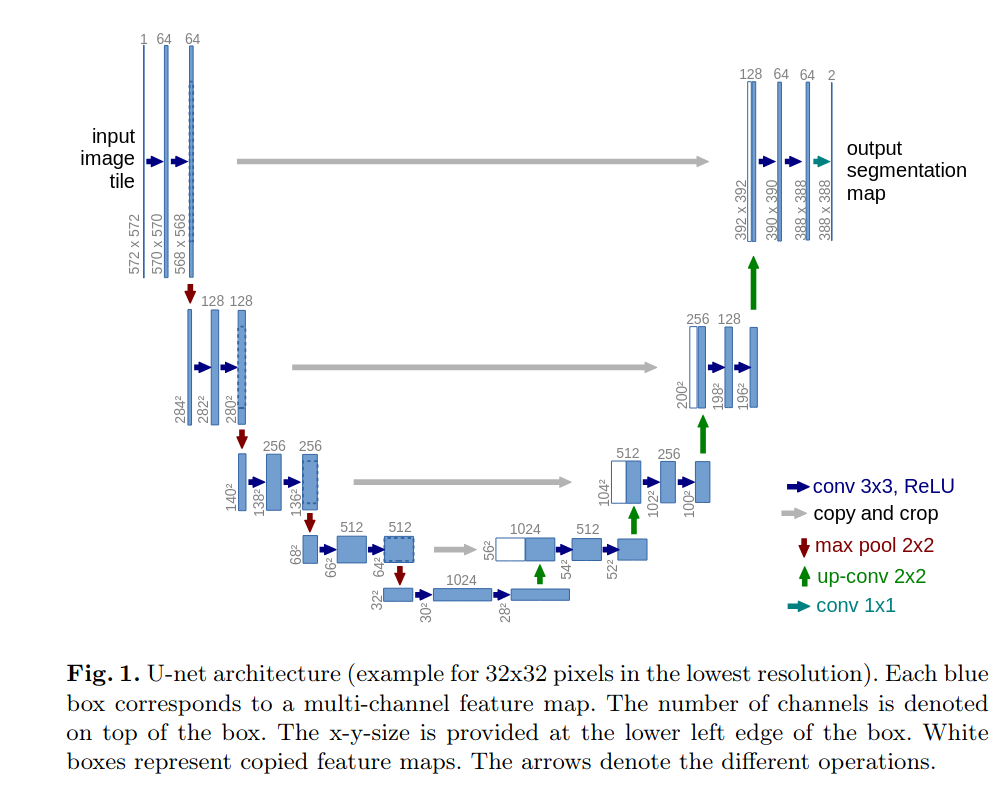

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

# explain the line of code below
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Double convolution
Questions:
1. From the network diagram above, code an elementary brick composed of a convolution layer.Do the same but limiting to a single convolution layer.

In [8]:
 #Conv2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d ->  ReLU#
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
           # First Conv2d -> BatchNorm2d -> ReLU
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),  # bias=False (since BatchNorm is used)
            nn.BatchNorm2d(out_channels),  # Add BatchNorm
            nn.ReLU(inplace=True),  # ReLU activation function

            # Second Conv2d -> BatchNorm2d -> ReLU
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),  # bias=False (since BatchNorm is used)
            nn.BatchNorm2d(out_channels),  # Add BatchNorm
            nn.ReLU(inplace=True)  # ReLU activation function
            )


    def forward(self, x):
        return self.conv(x)

In [9]:
# The same but with only one sequence
class SimpleConv(nn.Module):
  def __init__(self, in_channels, out_channels,kernel_size=3):
        super(SimpleConv, self).__init__()
        self.conv = nn.Sequential(
            # Conv2d -> BatchNorm2d -> ReLU
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),  # bias=False (since BatchNorm is used)
            nn.BatchNorm2d(out_channels),  # BatchNorm layer
            nn.ReLU(inplace=True)  # ReLU activation function

        )
  def forward(self, x):
        return self.conv(x)


## Model
https://arxiv.org/pdf/1505.04597.pdf

Questions :
1.  Complete the model code from the publication schema.
2.  Complete the descending part then the rising part of the Unet.
3.  For the rising part, use ConvTranspose2d
4.  Use the DoubleConv function first and then the SimpleConv, make comments

In [10]:
import torch.nn.functional as F


class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # downsize the image size

        # Down part of UNET
        ##
        for feature in features: # loop the features[64,128,256,512] 4 times
        # conv = expand the channel size from in_channel to feature
            self.downs.append(DoubleConv(in_channels, feature)) # implement doubleconvolution and add to self.downs
            in_channels = feature # update the in_channels

        self.bottleneck = SimpleConv(in_channels, in_channels*2)
        in_channels = in_channels*2

        # Up part of UNET
        for feature in features[-1::-1]:
            self.ups.append(nn.ConvTranspose2d(in_channels, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(in_channels, feature))
            in_channels = feature
        #for feature in reversed(features): # reverse the features such as [512,256,128,64] to decrease the channel size
        #    self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) # downsize the channel size first and magnify the image size
        #    self.ups.append(DoubleConv(feature * 2, feature)) # Refine the channels and maintain the image size

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) # change the channel size from 64 to 1. kernal size 1 means that we use 1*1 convolution which doesnt change the image size but channel size

        ##


    def forward(self, x):
        skip_connections = [] # (batch, channel, height, width)

        for down in self.downs:
            x = down(x) # x (batch, channle, height, width)
            skip_connections.append(x)
            x = self.pool(x) # downsize the image size

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])#height, width

            concat_skip = torch.cat((skip_connection, x), dim=1) # add channels
            x = self.ups[idx+1](concat_skip) # implement double convolution 4 times

        return self.final_conv(x)


# Evaluation metric
Evaluation metrics are quantitative measures used to assess the performance and effectiveness of a statistical or machine learning model. These metrics provide insights into how well the model is performing and help in comparing different models or algorithms.

https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/

Q: Write a function which calculates the accuracy which is the number of pixels OK compared to the total number of pixels and which calculates the dice score. This function will return the dice score as a validation metric.
Comment on the use of model.eval() and model.train()

Answer :

In U-Net, model.train() and model.eval() work differently because of Dropout and Batch Normalization layers.
In model.train(), Dropout randomly turns off some neurons to prevent overfitting, and Batch Normalization keeps updating its internal statistics. This helps the model learn from the training data. In model.eval(), Dropout is turned off, and Batch Normalization stops updating and uses fixed statistics instead. This makes predictions more stable during validation and testing.So, in U-Net, train() helps the model learn better, while eval() makes sure the evaluation is accurate and not affected by randomness.

In [11]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y_true in loader:
          x ,y_true = x.to(device), y_true.to(device)
          predictions = model(x)
          y_pred = torch.sigmoid(predictions).squeeze(1)
          #
          predicted = y_pred.view(-1)
          target = y_true.view(-1)
          #y_pred = (y_pred > 0.5).float()  # make y_pred as a binary

          intersection = (predicted*target).sum()  # find the intersection to calculate the dice score
          union = predicted.sum()+target.sum()
          dice = (2. * intersection+1e-6) / (union + 1e-8)  # correctly call sum() method


          #

          dice_score += dice.item() # let dice be a numeric valu from tensor
          num_correct += (y_pred == y_true).sum().item()   # Get the pixels correctly classified
          num_pixels += torch.numel(y_true)        # Get the total number of pixels



    val_accuracy = dice_score/len(loader) # derive the average accuracy

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {val_accuracy}")
    model.train()

    return val_accuracy


# Training
https://www.analyticsvidhya.com/blog/2023/01/gradient-descent-vs-backpropagation-whats-the-difference/

In [12]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pdb
import torchvision
import torch.nn.functional as F

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
IMAGE_HEIGHT = 128  # 1280 originally
IMAGE_WIDTH = 256  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Hyper parameters

In [13]:
class HyperParameters:
    def __init__(self, learning_rate, batch_size,epoch_numbers):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epoch_numbers = epoch_numbers

## Train function
Qestions
1. Write a function that calculates the loss on validation data.
2. Write a function that saves an image and the network prediction for each epoch to visualize the learning progress.
3. Write a function that calculates the loss on training data.
4. Make a comment on optimizer.zero_grad(), scaler.scale(loss).backward(),scaler.step(optimizer), scaler.update()


Answer :

First, optimizer.zero_grad() clears the old gradients. If we don’t do this, the gradients will add up, and the model will learn the wrong way.

Next, scaler.scale(loss).backward() calculates how much the model needs to change by computing gradients. Then, scaler.step(optimizer) updates the model using the gradients. But it only happens if the gradients are not too small or too big, which helps keep training stable. Finally, scaler.update() adjusts the scaling factor for the next step. This makes sure the model trains safely without causing very small or very large numbers that can break learning.




In [14]:
def check_val_loss(loader, model,loss_fn, device="cuda"):
    totalValLoss = 0.0
    model.eval()

    with torch.no_grad():
        for data, targets in loader:
          data, targets = data.to(device), targets.to(device) # transfer the data and target to cpu or gpu
          outputs = model(data)
          outputs = outputs.squeeze(dim=1)
          loss = loss_fn(outputs, targets)
          totalValLoss += loss.item()


    val_loss = totalValLoss/len(loader)
    print(f"Val loss: {val_loss}")
    model.train()

    return val_loss

def save_eval(loader, model,epoch,file_path="eval_image", device="cuda"):

    model.eval()

    with torch.no_grad():
        val_images, val_masks = next(iter(loader)) # call the first batch of data
        val_images = val_images.to(device) # make input image data to transfer to gpu/cpu to allow them to be calculated
        filename = file_path +"_" +str(epoch)
        predictions = model(val_images)
        preds = torch.sigmoid(predictions)
        preds = preds.squeeze(dim=1)
        # save eval
        torchvision.utils.save_image(
            preds, f"{filename}_predictions.png"
        )
        torchvision.utils.save_image(
            val_images, f"{filename}_images.png"
        )
        torchvision.utils.save_image(
            val_masks, f"{filename}_masks.png"
        ) # save the file with an extension to clarify the type of file

    model.train()


In [15]:
def train_fn(loader, model, optimizer, loss_fn, scaler, device="cuda"):
    loop = tqdm(loader, total=len(loader), desc="Training")
    totalTrainLoss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device) # send data to gpu/cpu to be able to conpute
        targets = targets.to(device) # send target to gpu/cpu to be able to conpute

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            predictions = predictions.squeeze(dim=1)
            loss =  loss_fn(predictions,targets)
            totalTrainLoss += loss.item() # += loss

        # backward
        optimizer.zero_grad() # resets the gradients to prevent accumulation from previous iterations
        scaler.scale(loss).backward() # Increases the loss value to prevent gradient underflow. & Computes gradients for the loss (but does not update weights).
        scaler.step(optimizer) # Restores the scaled gradients to their original size before updating the weights.
        scaler.update()#Adjusts the scaling factor for the next batch to optimize training stability.

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

    #...#
    train_loss = totalTrainLoss/len(loader)
    print(f"Tain loss: {train_loss}")

    return train_loss


## Training script
Questions:
1. Write a function wich plot and save train_loss, val_loss and val_acc
2. Write a function which save ckeckpoint file
3. Make a comment on:
A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            )
4.  Why are transformations missing for validation data?
5.  Why  nn.BCEWithLogitsLoss() is used instead of classical BCE?
6.  Make a comment on: torch.cuda.amp.GradScaler()
7.  What is Adam? What’s the main difference between Adam and SGD?

Answer
- 3 : This resizes the image to a fixed height and width. It ensures that all images have the same size, which is important because neural networks require consistent input dimensions.

- 4 : I think we don’t use transformations for validation because we want to test the model on clean images. In training, transformations help the model learn different variations, but in validation, we need to see how well it performs on real, unchanged images. If we modify validation data, the results wouldn’t be fair.

- 5 : BCEWithLogitsLoss() is better because it includes sigmoid inside, so we don’t have to apply it separately. This makes training more stable and prevents numerical issues. It also works directly with raw model outputs (logits), making it faster and more efficient.
- 6 : I think GradScaler() helps the model train faster and use less memory by using mixed precision (FP16 + FP32). It allows some calculations to run in lower precision while keeping training stable. This is useful for training large models on GPUs.

- 7 :  Adam is an optimizer that adjusts learning rates automatically, while SGD uses a fixed learning rate. Adam is usually faster and works better with noisy data, but SGD can sometimes generalize better. Adam helps when we don’t want to fine-tune the learning rate too much.

In [17]:
import matplotlib.pyplot as plt

class Results:
      def __init__(self,file_path="results"):
        self.result_dict = {
	             "train_loss": [],
	              "val_loss": [],
	              "val_acc": []
                }
        self.path = file_path

      def add_result(self, train_loss, val_loss,val_acc):
        self.result_dict["train_loss"].append(train_loss)
        self.result_dict["val_loss"].append(val_loss)
        self.result_dict["val_acc"].append(val_acc)

      def plotAndSave(self,n_epoch):
        filename = f"{self.path}_{n_epoch}.png"

        epochs = range(1, len(self.result_dict["train_loss"]) + 1)

        fig, ax1 = plt.subplots(figsize=(8, 6))

        # Plot losses on primary Y-axis
        ax1.plot(epochs, self.result_dict["train_loss"], label="Train Loss", color="blue", linestyle="-", marker="o")
        ax1.plot(epochs, self.result_dict["val_loss"], label="Validation Loss", color="red", linestyle="-", marker="o")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Loss")
        ax1.set_title("Training and Validation Loss")
        ax1.legend(loc="upper left")
        ax1.grid(True)

        # Create a secondary Y-axis for validation accuracy
        ax2 = ax1.twinx()
        ax2.plot(epochs, self.result_dict["val_acc"], label="Validation Accuracy", color="green", linestyle="--", marker="s")
        ax2.set_ylabel("Accuracy")
        ax2.legend(loc="upper right")

        # Save the plot
        plt.savefig(filename)
        plt.show()
        print(f"Plot saved as {filename}")



In [18]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print(f"=> Saving checkpoint: {filename}")
    torch.save(state, filename)

def load_checkpoint(checkpoint_path, model, device="cuda"):
    print(f"=> Loading checkpoint: {checkpoint_path}")
    #load
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])

    epoch = checkpoint.get("epoch", 0)  # Default to epoch 0 if not found
    print(f"Checkpoint loaded (Epoch {epoch})")

    return epoch  # Return the saved epoch (useful for resuming training)


def run_training(hyper_parameters):

    results = Results(file_path = PLOT_PATH)
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET().to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=hyper_parameters.learning_rate)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        hyper_parameters.batch_size,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


    check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(hyper_parameters.epoch_numbers):
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model (check point)
        #
        checkpoint = {
        'epoch': epoch,  # The current epoch number
        "model_state_dict": model.state_dict(),  # Save the model's learned parameters (weights)
        "optimizer_state_dict": optimizer.state_dict(),  # Save the optimizer's state (e.g., learning rate, momentum)

    }

    # Save the checkpoint to a file with the current epoch in the filename
        save_checkpoint(checkpoint, filename=CHECKPOINT_PATH)
        #

        val_loss = check_val_loss(val_loader, model,loss_fn)

        # check accuracy
        val_accuracy = check_accuracy(val_loader, model, device=DEVICE)

        results.add_result(train_loss, val_loss,val_accuracy)

        results.plotAndSave(epoch)
        save_eval(val_loader, model,epoch,PLOT_VAL_PATH, device=DEVICE)
    return model

# Run Training

<ipython-input-18-586bde345232>:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Got 0/117800960 with acc 0.00
Dice score: 0.4871527884937356


Training:   0%|          | 0/1247 [00:00<?, ?it/s]<ipython-input-15-cbcaebdefb2e>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 1247/1247 [01:39<00:00, 12.47it/s, loss=0.0711]


Tain loss: 0.07399671443297881
=> Saving checkpoint: /content/drive/MyDrive/Unet/Save/my_checkpoint.pth.tar
Val loss: 0.03711177819772854
Got 0/117800960 with acc 0.00
Dice score: 0.9778850929449382


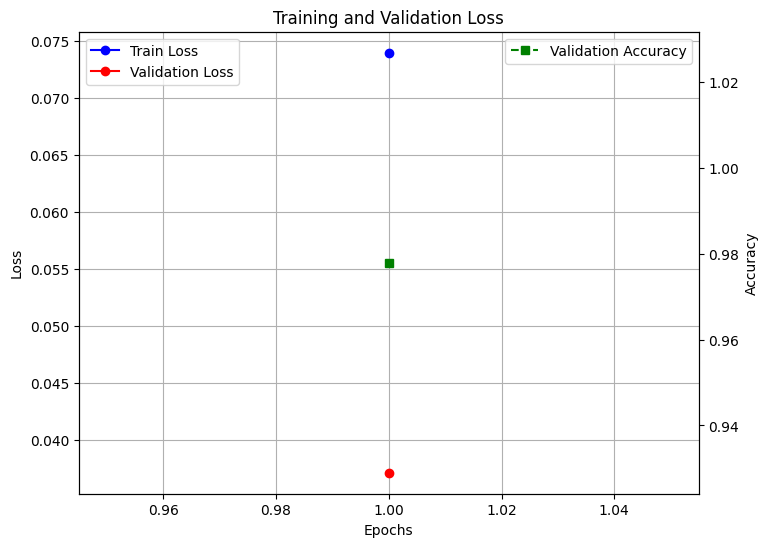

Plot saved as /content/drive/MyDrive/Unet/Save/Accuracy_0.png


UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [23]:
hyper_parameters = HyperParameters(learning_rate = 1e-4, batch_size = 4, epoch_numbers = 1)
run_training(hyper_parameters)

<ipython-input-18-586bde345232>:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Got 0/117800960 with acc 0.00
Dice score: 0.485524354514333


Training:   0%|          | 0/1247 [00:00<?, ?it/s]<ipython-input-15-cbcaebdefb2e>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 1247/1247 [01:35<00:00, 13.11it/s, loss=0.0219]


Tain loss: 0.08793917019221684
=> Saving checkpoint: /content/drive/MyDrive/Unet/Save/my_checkpoint.pth.tar
Val loss: 0.029059883261224596
Got 0/117800960 with acc 0.00
Dice score: 0.9789333952380087


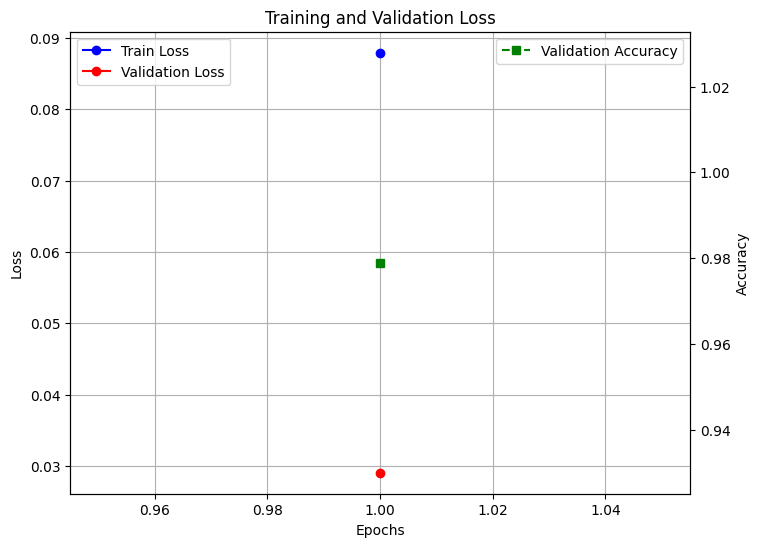

Plot saved as /content/drive/MyDrive/Unet/Save/Accuracy_0.png


Training: 100%|██████████| 1247/1247 [01:33<00:00, 13.36it/s, loss=0.0111]


Tain loss: 0.027530854028920658
=> Saving checkpoint: /content/drive/MyDrive/Unet/Save/my_checkpoint.pth.tar
Val loss: 0.014921692296807553
Got 0/117800960 with acc 0.00
Dice score: 0.9899828836609118


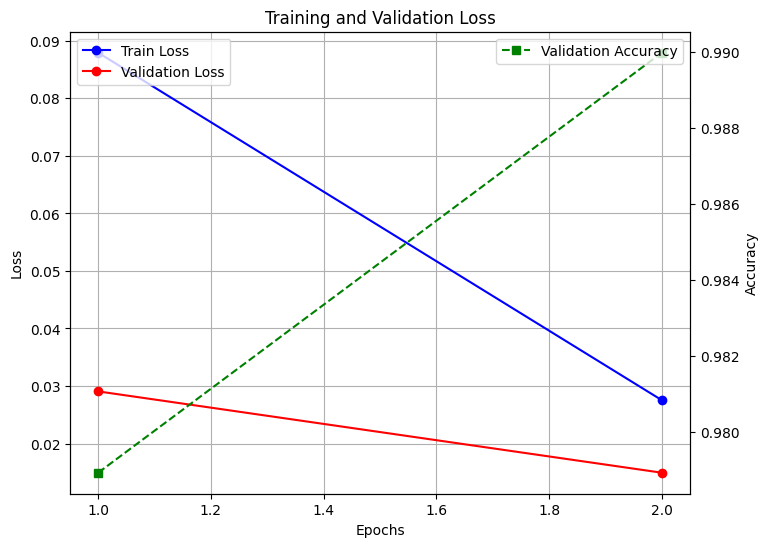

Plot saved as /content/drive/MyDrive/Unet/Save/Accuracy_1.png


Training: 100%|██████████| 1247/1247 [01:34<00:00, 13.14it/s, loss=0.00849]


Tain loss: 0.01766118820595354
=> Saving checkpoint: /content/drive/MyDrive/Unet/Save/my_checkpoint.pth.tar
Val loss: 0.01235883223413836
Got 0/117800960 with acc 0.00
Dice score: 0.993030007612894


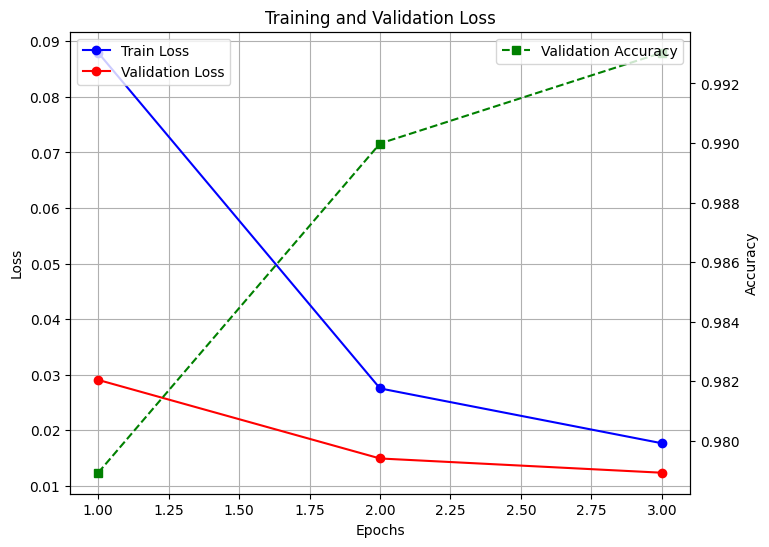

Plot saved as /content/drive/MyDrive/Unet/Save/Accuracy_2.png


Training: 100%|██████████| 1247/1247 [01:34<00:00, 13.19it/s, loss=0.0286]


Tain loss: 0.017650059342525726
=> Saving checkpoint: /content/drive/MyDrive/Unet/Save/my_checkpoint.pth.tar
Val loss: 0.010827892598188794
Got 0/117800960 with acc 0.00
Dice score: 0.9930842392759732


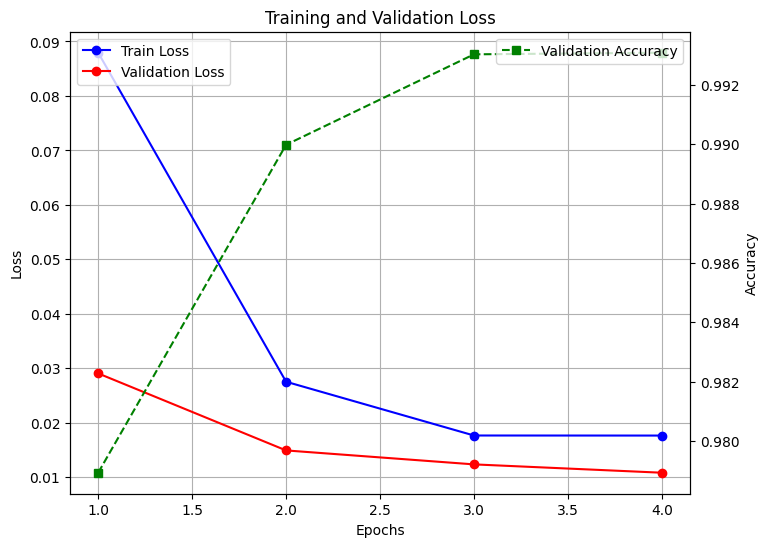

Plot saved as /content/drive/MyDrive/Unet/Save/Accuracy_3.png


Training: 100%|██████████| 1247/1247 [01:35<00:00, 13.06it/s, loss=0.00962]


Tain loss: 0.015345046472899528
=> Saving checkpoint: /content/drive/MyDrive/Unet/Save/my_checkpoint.pth.tar
Val loss: 0.011358752852171961
Got 0/117800960 with acc 0.00
Dice score: 0.9925411610665819


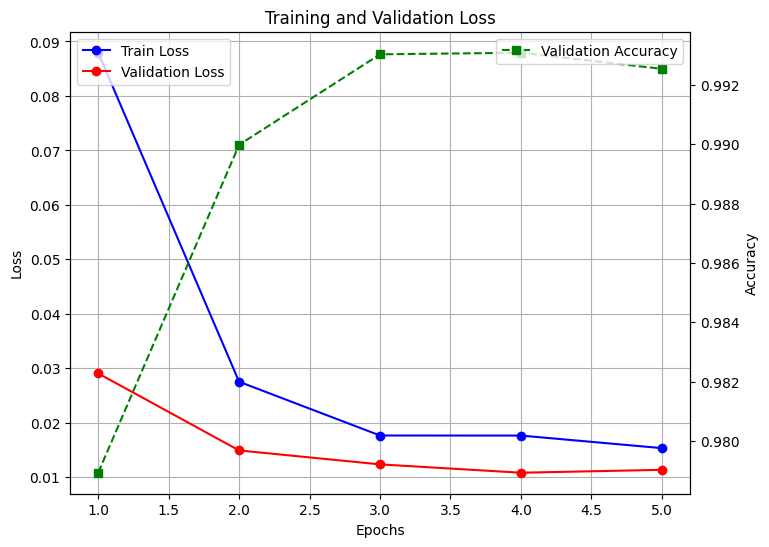

Plot saved as /content/drive/MyDrive/Unet/Save/Accuracy_4.png


Training: 100%|██████████| 1247/1247 [01:32<00:00, 13.52it/s, loss=0.101]


Tain loss: 0.013342132713631836
=> Saving checkpoint: /content/drive/MyDrive/Unet/Save/my_checkpoint.pth.tar
Val loss: 0.01046925812998678
Got 0/117800960 with acc 0.00
Dice score: 0.9943386489321346


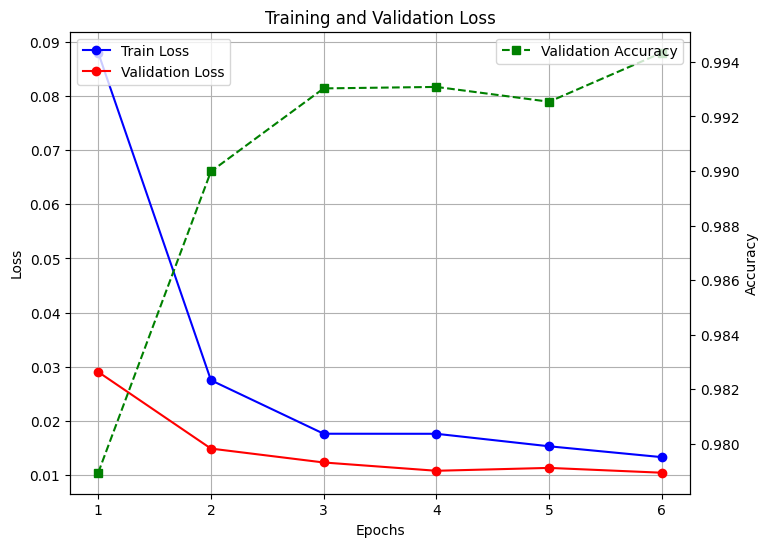

Plot saved as /content/drive/MyDrive/Unet/Save/Accuracy_5.png


Training: 100%|██████████| 1247/1247 [01:32<00:00, 13.45it/s, loss=0.0105]


Tain loss: 0.01381038332341525
=> Saving checkpoint: /content/drive/MyDrive/Unet/Save/my_checkpoint.pth.tar
Val loss: 0.009662365036560969
Got 0/117800960 with acc 0.00
Dice score: 0.9944957003630058


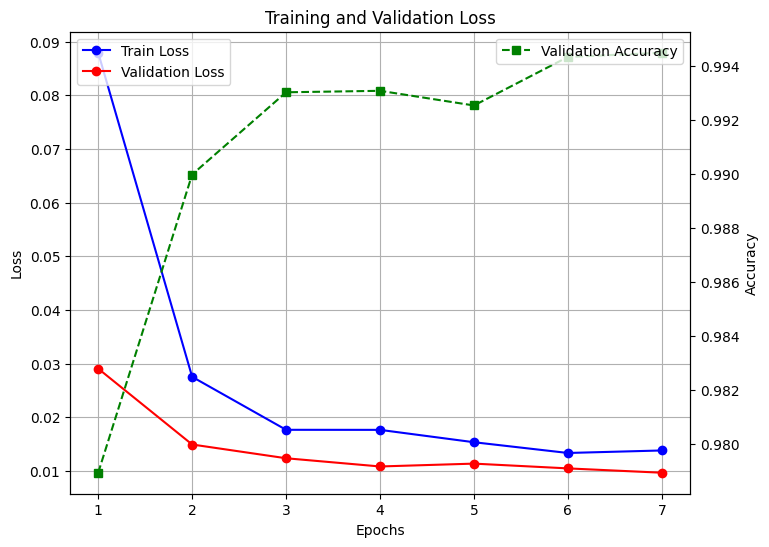

Plot saved as /content/drive/MyDrive/Unet/Save/Accuracy_6.png


Training: 100%|██████████| 1247/1247 [01:32<00:00, 13.44it/s, loss=0.0586]


Tain loss: 0.011018015342509062
=> Saving checkpoint: /content/drive/MyDrive/Unet/Save/my_checkpoint.pth.tar
Val loss: 0.008021261946283923
Got 0/117800960 with acc 0.00
Dice score: 0.994984404159525


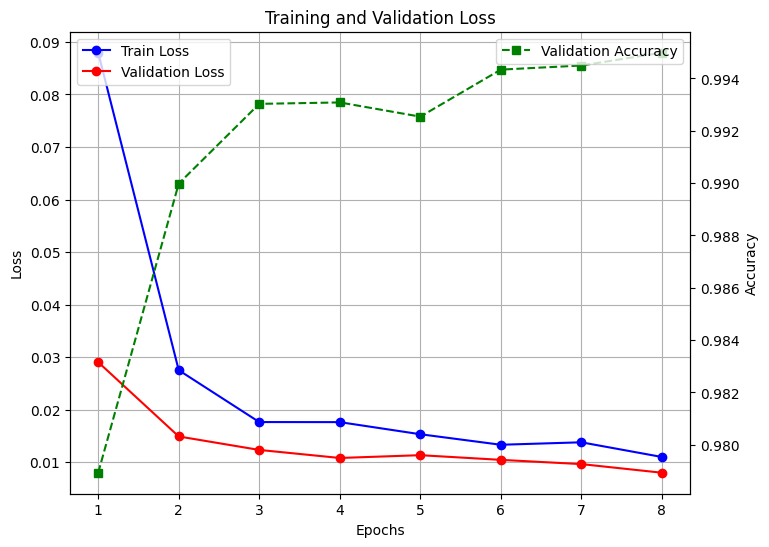

Plot saved as /content/drive/MyDrive/Unet/Save/Accuracy_7.png


Training: 100%|██████████| 1247/1247 [01:36<00:00, 12.98it/s, loss=0.00563]


Tain loss: 0.010522698986685841
=> Saving checkpoint: /content/drive/MyDrive/Unet/Save/my_checkpoint.pth.tar
Val loss: 0.01686004503415315
Got 0/117800960 with acc 0.00
Dice score: 0.992419929279582


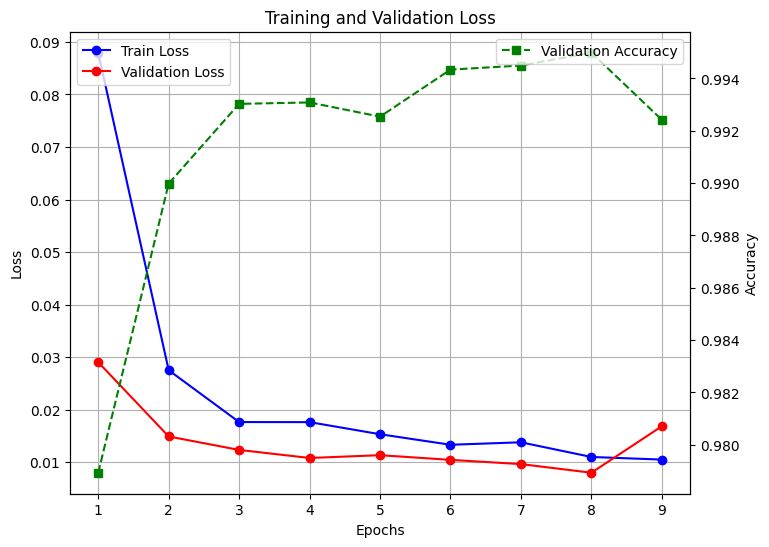

Plot saved as /content/drive/MyDrive/Unet/Save/Accuracy_8.png


Training: 100%|██████████| 1247/1247 [01:37<00:00, 12.80it/s, loss=0.00449]


Tain loss: 0.012330642747103914
=> Saving checkpoint: /content/drive/MyDrive/Unet/Save/my_checkpoint.pth.tar
Val loss: 0.00986135309446638
Got 0/117800960 with acc 0.00
Dice score: 0.9952591129582327


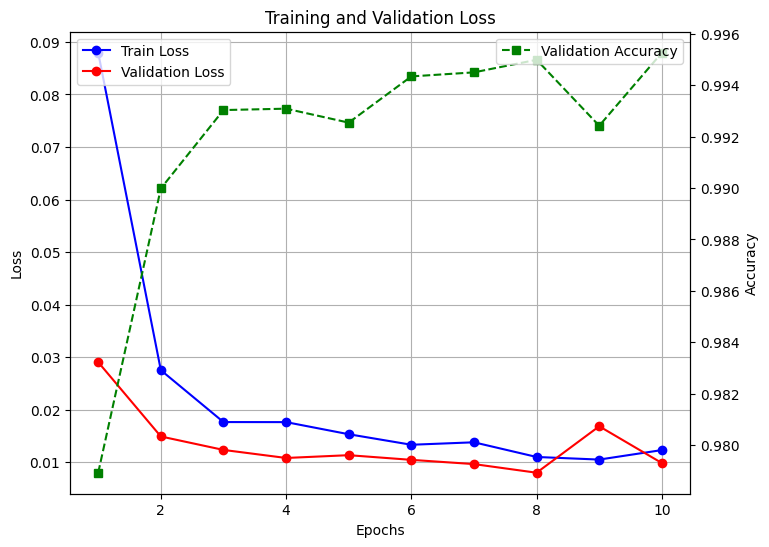

Plot saved as /content/drive/MyDrive/Unet/Save/Accuracy_9.png


UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [25]:
hyper_parameters = HyperParameters(learning_rate = 1e-4, batch_size = 4, epoch_numbers = 10)
run_training(hyper_parameters)

# Evaluation

=> Loading checkpoint: /content/drive/MyDrive/Unet/Save/my_checkpoint.pth.tar


<ipython-input-18-586bde345232>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Checkpoint loaded (Epoch 9)
y size : torch.Size([4, 1, 128, 256])
preds size: torch.Size([4, 1, 128, 256])
y size : torch.Size([4, 1, 128, 256])
preds size: torch.Size([4, 1, 128, 256])


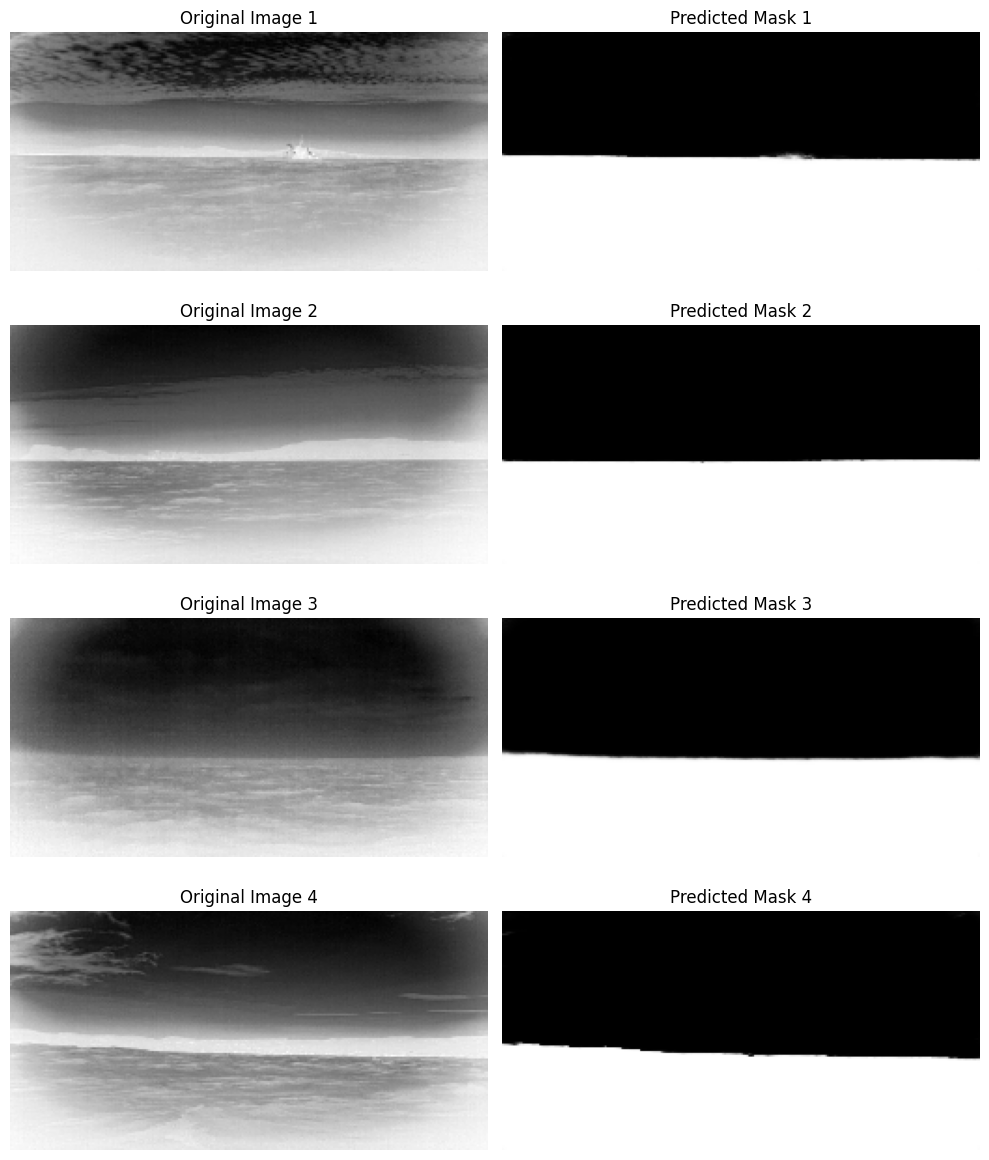

Model saved to /content/drive/MyDrive/Unet/unet_model_final.pth


In [33]:
import albumentations as A

model = UNET().to(DEVICE)
load_checkpoint(CHECKPOINT_PATH, model, device='cpu')

val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_ds = HorizonDataset(
        image_dir=VAL_IMG_DIR,
        mask_dir=VAL_MASK_DIR,
        transform=val_transforms
    )

val_loader = DataLoader(
        val_ds,
        batch_size= 4,
        num_workers=2,
        pin_memory=True,
        shuffle=False
)

val_images, val_masks = next(iter(val_loader))

data = val_images.to(DEVICE)
y =model(data)

preds = torch.sigmoid(y)
print(f"y size : {y.size()}")
print(f"preds size: {preds.size()}")

preds = preds.detach().cpu().numpy()

preds = torch.sigmoid(y)
print(f"y size : {y.size()}")
print(f"preds size: {preds.size()}")

preds = preds.detach().cpu().numpy()


num_samples = min(5, val_images.size(0))  # val_images.size(0) gives the batch size

# Create subplots
f, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))

for i in range(num_samples):
    # Original Image (first column)
    axes[i, 0].imshow(val_images[i][0].cpu(), cmap="gray")
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 0].axis("off")  # Remove axes

    # Predicted Mask (second column)
    axes[i, 1].imshow(preds[i][0], cmap="gray")
    axes[i, 1].set_title(f"Predicted Mask {i+1}")
    axes[i, 1].axis("off")  # Remove axes

plt.tight_layout()  # Adjust layout
plt.show(block=True)

model_save_path = "/content/drive/MyDrive/Unet/unet_model_final.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")
